### Build Reproducible Experiments
In this notebook, the aim is to show you how to build a reproducible experiment within Azure. In this example, we're going to train a MNIST classifier using Tensorflow and show you how you can log and track your experiment as we go through the lab.

The reason we chose MNIST is to pick a very simple example as the main focus is to build a reproducible experiment and not to learn a new algorithm or to build a complex model.

**Important Note:**:

You can run this notebook on your local latop or Azure Notebooks (notebooks.azure.com)
- Local Laptop - the following packages has to be installed:
    - Azureml-SDK - with notebook,widget extensions
    - tensorflow==1.14
- Azure Notebooks:
    - This is a free notebook, all of the packages for an ML experiment is installed
- AzureML Notebook:
    - This is a premium notebook that you can choose the VM type.
You need to have AzureML SDK installed before running this notebook.

In addition, you need to create an Azure Free credit. After creating your free subscription, create an Azure Machine Learning Workspace in WestUS2.

First we download the MNIST sample files from Yann Lecun website!

In [1]:
import os
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')


('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x1db12e25148>)

Import a bunch of packages.

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt


Import the AzureML SDK package to be able to communicate with Azure ML Services

In [3]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)


SDK version: 1.0.65


In [4]:
# from azureml.telemetry import set_diagnostics_collection
# set_diagnostics_collection(send_diagnostics = True)


First you need to go to Azure Portal and create:
* Resource Group
* Azure Machine Learning Workspace in US West 2


In [5]:
# Your subscription ID will be different replace the stirng with yours
subscription_id = "ed70929a-e125-4daf-8945-04f709d2c75e" 
resource_group = "MLOpsWorkshop"
workspace_name = "FirstExample"
workspace_region = "westus2"

Initiate an object from Workspace class. the Workspace object will point to the created Workspace we created through the portal

In [6]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.

from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

In [7]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')


Workspace name: FirstExample
Azure region: westus2
Subscription id: ed70929a-e125-4daf-8945-04f709d2c75e
Resource group: MLOpsWorkshop


### Start a new Experiment

In software engineering world we have a new feature to develop. In ML/Data Science world, we work on experiments.

Here we create a new experiment, we want to make sure everything related to this experiment is saved within this experiment.

In [8]:
from azureml.core import Experiment

exp = Experiment(workspace=ws, name='tracking-logs')

### Track and Log Metrics

Every Experiment comes with some metrics to collect. This can be a single value for the accuracy of an ML model, a list of values representing a distribution or simply and image showing a plot.
Within the experiment object, we can start logging important metrics that we want to make sure are accessible and saved after we're done with this experiment.

In [21]:
# Initializing log tracking action by creating a Run object in the Experiment
run =  exp.start_logging()

Each Run can represent one of our hypothesis that we want to test. For that Hypothesis we start to collect metrics.

In [22]:
run.get_status()

'Running'

In [34]:
run.get_details()

{'runId': '3e943ed5-804b-41fc-afab-e351285371b5',
 'target': 'sdk',
 'status': 'Running',
 'startTimeUtc': '2019-10-10T15:27:52.484221Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/classicboyir/reproducible-experiments.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/reproducible-experiments.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'mlflow.source.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': 'c317cd9d-e107-491f-ac42-b37b7bed4dc8'},
 'inputDatasets': [],
 'logFiles': {}}

In [35]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [26]:
run.log('metric_1', 1.1)

In [27]:
run.log('metric_1', 2.0)

In [28]:
run.log('metric_1', 2.0)

In [29]:
run.log('metric_1', 4.0)

In [30]:
run.log('metric_1', 4.0)

In [31]:
run.log('metric_1', 2.5)

In [32]:
run.log('metric_1', 6.3)

In [36]:
# Log some metrics about the input dataset:
    
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

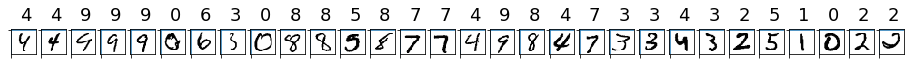

In [37]:
# Record how the input dataset looks like
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
    
run.log_image(name='{}-samples-of-input-dataset'.format(sample_size), plot=plt)

In [38]:
import pandas as pd
dist = pd.DataFrame(data=y_train, columns=['test_values'])['test_values'].value_counts()

run.log_table('digit_dist', {"count":list(dist.values), "digits":list(dist.index)})

In [39]:
X_train.shape

(60000, 784)

In [40]:
run.log('train_dataset_size', X_train.shape[0])

In [41]:
run.log('test_dataset_size', X_test.shape[0])

### Traditional way of running a experiment
Now run a simple Tensorflow job here to train an image classifier base off of MNIST dataset. This example requires Tensorflow 1 (1.14 in this case)  

In [42]:
import numpy as np
import argparse
import os
import tensorflow as tf
from utils import load_data

data_folder = os.path.join('data', 'mnist')

print('training dataset is stored here:', data_folder)

training_set_size = X_train.shape[0]

n_inputs = 28 * 28
n_h1 = 100
n_h2 = 100
n_outputs = 10
learning_rate = 0.01
n_epochs = 20
batch_size = 50

with tf.name_scope('network'):
    # construct the DNN
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name='y')
    h1 = tf.layers.dense(X, n_h1, activation=tf.nn.relu, name='h1')
    h2 = tf.layers.dense(h1, n_h2, activation=tf.nn.relu, name='h2')
    output = tf.layers.dense(h2, n_outputs, name='output')

with tf.name_scope('train'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output)
    loss = tf.reduce_mean(cross_entropy, name='loss')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(output, y, 1)
    acc_op = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')


WARNING - From <ipython-input-42-2b90fbe99597>:25: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
WARNING - From c:\users\hosarsha\appdata\local\conda\conda\envs\azureml\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


training dataset is stored here: data\mnist
0 -- Training accuracy: 0.8 Validation accuracy: 0.9
1 -- Training accuracy: 0.96 Validation accuracy: 0.9143
2 -- Training accuracy: 0.98 Validation accuracy: 0.9256
3 -- Training accuracy: 0.98 Validation accuracy: 0.9336
4 -- Training accuracy: 0.92 Validation accuracy: 0.938
5 -- Training accuracy: 0.94 Validation accuracy: 0.9426
6 -- Training accuracy: 0.96 Validation accuracy: 0.9455
7 -- Training accuracy: 0.94 Validation accuracy: 0.9488
8 -- Training accuracy: 0.98 Validation accuracy: 0.9515
9 -- Training accuracy: 0.96 Validation accuracy: 0.956
10 -- Training accuracy: 0.98 Validation accuracy: 0.9579
11 -- Training accuracy: 0.92 Validation accuracy: 0.9597
12 -- Training accuracy: 0.96 Validation accuracy: 0.9602
13 -- Training accuracy: 1.0 Validation accuracy: 0.9617
14 -- Training accuracy: 0.92 Validation accuracy: 0.9632
15 -- Training accuracy: 0.96 Validation accuracy: 0.9642
16 -- Training accuracy: 0.96 Validation accu

### Make this job more reproducible - Still the Manual Way

A more manual way of tracking metrics - (the better approach will be discussed later today)

**Tracking the metrics**

In [44]:
# Log Hyper Parameters

run.log_row('Hyper Parameters',
        n_inputs=n_inputs,
        n_h1=n_h1,
        n_h2=n_h2,
        n_outputs=n_outputs,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        batch_size=batch_size)

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        run.log('accuracy-train', acc_train)
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})
        run.log('accuracy-val', acc_val)

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    run.log('final-accuracy', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')
    run.upload_folder('/outputs/model/', './outputs/')

0 -- Training accuracy: 0.8 Validation accuracy: 0.8968
1 -- Training accuracy: 0.92 Validation accuracy: 0.9166
2 -- Training accuracy: 0.86 Validation accuracy: 0.9266
3 -- Training accuracy: 0.96 Validation accuracy: 0.9314
4 -- Training accuracy: 0.98 Validation accuracy: 0.9393
5 -- Training accuracy: 0.94 Validation accuracy: 0.9442
6 -- Training accuracy: 0.94 Validation accuracy: 0.9488
7 -- Training accuracy: 0.96 Validation accuracy: 0.9526
8 -- Training accuracy: 0.94 Validation accuracy: 0.9552
9 -- Training accuracy: 0.96 Validation accuracy: 0.9572
10 -- Training accuracy: 0.94 Validation accuracy: 0.9589
11 -- Training accuracy: 0.96 Validation accuracy: 0.962
12 -- Training accuracy: 0.96 Validation accuracy: 0.9636
13 -- Training accuracy: 0.94 Validation accuracy: 0.9646
14 -- Training accuracy: 0.98 Validation accuracy: 0.9663
15 -- Training accuracy: 1.0 Validation accuracy: 0.9669
16 -- Training accuracy: 0.98 Validation accuracy: 0.9679
17 -- Training accuracy: 0.

In [43]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [49]:
# Collect all or one of the metrics:

print('metric_1: ', run.get_metrics('metric_1'))

run.get_metrics()

metric_1 {'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3]}


{'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3],
 '30-samples-of-input-dataset': 'aml://artifactId/ExperimentRun/dcid.3e943ed5-804b-41fc-afab-e351285371b5/30-samples-of-input-dataset_1570721355.png',
 'digit_dist': {'count': [6742,
   6265,
   6131,
   5958,
   5949,
   5923,
   5918,
   5851,
   5842,
   5421],
  'digits': [1, 7, 3, 2, 9, 0, 6, 8, 4, 5]},
 'train_dataset_size': 60000,
 'test_dataset_size': 10000,
 'Hyper Parameters': {'n_inputs': 784,
  'n_h1': 100,
  'n_h2': 100,
  'n_outputs': 10,
  'learning_rate': 0.01,
  'n_epochs': 20,
  'batch_size': 50},
 'accuracy-train': [0.800000011920929,
  0.9200000166893005,
  0.8600000143051147,
  0.9599999785423279,
  0.9800000190734863,
  0.9399999976158142,
  0.9399999976158142,
  0.9599999785423279,
  0.9399999976158142,
  0.9599999785423279,
  0.9399999976158142,
  0.9599999785423279,
  0.9599999785423279,
  0.9399999976158142,
  0.9800000190734863,
  1,
  0.9800000190734863,
  0.9399999976158142,
  0.9800000190734863,
  0.980000019073486

In [50]:
run.complete()

In [55]:
from azureml.core import ScriptRunConfig
ScriptRunConfig?

In [60]:
'..\\' + data_folder

'..\\data\\mnist'

### Submit the TF job to a Remote Computer

#### Creating a remote computer

This is to make a remote instance to run our TF job

In [41]:
# Create a GPU cluster of type NV6 with 1 node. (due to subscription's limitations we stick to 1 node)

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # CPU: Standard_D3_v2
    # GPU: Standard_NV6
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NV6', 
                                                           max_nodes=1,
                                                           min_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 1, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-10-10T16:12:06.692000+00:00', 'errors': None, 'creationTime': '2019-10-10T16:10:47.133007+00:00', 'modifiedTime': '2019-10-10T16:11:03.644102+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': ''}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NV6'}


In [42]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)


gpucluster AmlCompute Succeeded


### Register Dataset

As part of building a reproducible experiment, we need to separate the input data from the code and also from the compute environment.

There are multiple ways to register a dataset within Azure ML. 

* Store it on the Blob storage and create a reference to the Experiment

* Register the source data as Dataset artifact and register it at the Workspace

#### Store the input data at a cloud storage (Blob storage)

In [45]:

import os
script_folder = os.path.join(os.getcwd(), "project-folder")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

C:\CloneOfOneDrive\Private\Talks\MLOps\Workshop Materials\Day1\ExperimentRepo\project-folder


In [92]:
ds = ws.get_default_datastore()
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_6a15e3cfdd5c4656aa653c4ac473bfde

In [93]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ws.get_default_datastore().as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=False, 
                 framework_version='1.13')


In [94]:
run = exp.submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
tracking-logs,tracking-logs_1570725323_7add8b27,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [95]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [34]:
from azureml.core.dataset import Dataset

web_paths = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

In [35]:
type(Dataset.File.from_files(path = web_paths))

azureml.data.file_dataset.FileDataset

In [39]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist_dataset',
                           description='training and test dataset',
                           create_new_version=True)

In [20]:
dataset = Dataset.get_by_name(workspace = ws, name='mnist_dataset')

In [21]:
dataset.to_path()

c:\users\hosarsha\appdata\local\conda\conda\envs\azureml\lib\site-packages\azureml\dataprep\api\dataflow.py:681: UserWarning: Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install azureml-dataprep[pandas].
  warnings.warn('Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. '


array(['/http/yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'],
      dtype=object)

In [52]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist_dataset').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 100,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['azureml-sdk','azureml-dataprep[pandas,fuse]>=1.1.14', 'tensorflow==1.14'])

env.python.conda_dependencies = cd

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist_dataset.py', 
                 environment_definition=env,
                 framework_version='1.13')

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.
WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['tensorflow']. We cannot guarantee image build will succeed.


In [ ]:
run = exp.submit(est)
run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

In [120]:
# run.cancel()

### Bonus: Hyperparameter tuning

In [96]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)


In [105]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ws.get_default_datastore().as_mount()},
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=True, 
                 framework_version='1.13')

In [106]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [108]:
htc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='accuracy-val', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=4,
                       max_concurrent_runs=2)

In [109]:
htr = exp.submit(config=htc)

In [110]:
RunDetails(htr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [103]:
# htr.cancel()
# compute_target.delete()

### Register the model

Once the training job is finished, you need to register the trained model in the Workspace's model management section.

In [111]:
best_run = htr.get_best_run_by_primary_metric()
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'azureml-logs/65_job_prep-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'logs/azureml/141_azureml.log', 'logs/azureml/azureml.log', 'outputs/model/checkpoint', 'outputs/model/mnist-tf.model.data-00000-of-00001', 'outputs/model/mnist-tf.model.index', 'outputs/model/mnist-tf.model.meta']


In [112]:
model = best_run.register_model(model_name='tf-dnn-mnist-project', model_path='outputs/model')

No go to the Workspace in the Azure Portal. Under the Model tab, you'll be able to see a model named **tf-dnn-mnist-project**

### Environment Dependencies

To provide other dependencies such as extra packages that need to be installed you can should provide the "environment_definition" to the Tensorflow class:

In [26]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)


gpucluster AmlCompute Succeeded


In [27]:
import shutil
# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)


'./tf-mnist\\utils.py'

In [34]:
%%bash

ls -lah

total 144K
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:07 .
drwxrwxrwx 1 hossein hossein 4.0K Oct  6 22:27 ..
drwxrwxrwx 1 hossein hossein 4.0K Oct  4 17:25 .azureml
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:38 data
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:06 .git
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:03 .ipynb_checkpoints
-rwxrwxrwx 1 hossein hossein 113K Oct  7 17:07 mnist_base_example.ipynb
drwxrwxrwx 1 hossein hossein 4.0K Oct  4 17:31 outputs
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:40 __pycache__
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:40 tf-mnist
-rwxrwxrwx 1 hossein hossein 4.0K Oct  7 16:17 tf_mnist.py
-rwxrwxrwx 1 hossein hossein 9.3K Oct  7 16:20 tf_mnist_with_summary.py
-rwxrwxrwx 1 hossein hossein 6.1K Oct  7 14:16 Untitled.ipynb
-rwxrwxrwx 1 hossein hossein  912 Oct  7 14:19 utils.py


In [37]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ws.get_default_datastore().as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=False, 
                 framework_version='1.13')


In [38]:
run = exp.submit(est)

In [39]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [40]:
run.wait_for_completion(show_output=True) # this provides a verbose log

RunId: tf-mnist_1570482481_e5a0a94d
Web View: https://mlworkspace.azure.ai/portal/subscriptions/ed70929a-e125-4daf-8945-04f709d2c75e/resourceGroups/MLOpsWorkshop/providers/Microsoft.MachineLearningServices/workspaces/FirstExample/experiments/tf-mnist/runs/tf-mnist_1570482481_e5a0a94d

Streaming azureml-logs/70_driver_log.txt

Starting the daemon thread to refresh tokens in background for process with pid = 141
Entering Run History Context Manager.
/opt/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _n

{'runId': 'tf-mnist_1570482481_e5a0a94d',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-10-07T21:08:15.557214Z',
 'endTimeUtc': '2019-10-07T21:09:28.365261Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '8e2edf9b-3a2c-4e8c-91ee-0d7d10cc8472',
  'azureml.git.repository_uri': 'https://github.com/classicboyir/reproducible-experiments.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/reproducible-experiments.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'mlflow.source.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'runDefinition': {'script': 'tf_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspaceblobstore',
   '--batch-size

In [41]:
run.get_details()

{'runId': 'tf-mnist_1570482481_e5a0a94d',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-10-07T21:08:15.557214Z',
 'endTimeUtc': '2019-10-07T21:09:28.365261Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '8e2edf9b-3a2c-4e8c-91ee-0d7d10cc8472',
  'azureml.git.repository_uri': 'https://github.com/classicboyir/reproducible-experiments.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/reproducible-experiments.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'mlflow.source.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'runDefinition': {'script': 'tf_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspaceblobstore',
   '--batch-size

In [28]:
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'azureml-logs/65_job_prep-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'logs/azureml/141_azureml.log', 'logs/azureml/azureml.log', 'outputs/model/checkpoint', 'outputs/model/mnist-tf.model.data-00000-of-00001', 'outputs/model/mnist-tf.model.index', 'outputs/model/mnist-tf.model.meta']


In [29]:
model = best_run.register_model(model_name='tf-dnn-mnist', model_path='outputs/model')